In [31]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Fellers Square Root Process (Cox-Ingersoll-Ross Model)

![Feller Square-Root Process](square-root_mean-reverting_process.png)

In [32]:
# Simulate the square root process
N_SIMS = 5000                            # FIXME: number of simulations
N_STEPS = 200                            # FIXME: number of steps (excluding t = 0)
ALPHA = 5                                # FIXME: mean reversion rate
SIGMA = 0.07                             # FIXME: volatility
MU = 0.07                                # FIXME: long-term mean
X0 = 0.03                                # FIXME: initial value
T = 1                                    # FIXME: time horizon

# Deriving Time Steps
dt = T / N_STEPS
t_steps = np.linspace(0, T, N_STEPS + 1)

# Theoretical Statistics
exact_mean = X0 * np.exp(-ALPHA * t_steps) + MU * (1 - np.exp(-ALPHA * t_steps))
exact_var = X0 * SIGMA**2 / (2 * ALPHA) * (np.exp(-ALPHA * t_steps) - np.exp(-2 * ALPHA * t_steps)) + MU * SIGMA**2 / (2 * ALPHA) * (1 - np.exp(-ALPHA * t_steps))**2

# Simulating
Z = np.random.normal(loc = 0, scale = 1, size = (N_STEPS, N_SIMS))
X = np.zeros((N_STEPS, N_SIMS))
X = np.vstack([np.full(N_SIMS, X0), X])
Y = X.copy()

# Gaussian Approximation with Analytical Moments # FIXME: to be corrected
for i in range(N_STEPS):
    drift = np.exp(-ALPHA * dt) * X[i] + MU * (1 - np.exp(-ALPHA * dt))
    diffusion = X[i] * (SIGMA**2 / ALPHA) * (np.exp(-ALPHA * dt) - np.exp(-2 * ALPHA * dt)) + MU * (SIGMA**2 / (2 * ALPHA)) * (1 - np.exp(-ALPHA * dt))**2
    X[i + 1] = drift + np.sqrt(np.maximum(diffusion, 0)) * Z[i] # np.maximum(var_t, 0) to correct for negative value from discretisation across all entries (cannot use np.max())

# Plain EM Method # FIXME: to be corrected
for i in range(N_STEPS):
    Y[i + 1] = Y[i] + ALPHA * (MU - Y[i]) * dt + SIGMA * np.sqrt(np.maximum(Y[i], 0) * dt) * Z[i] # Correct for negative value from discretisation

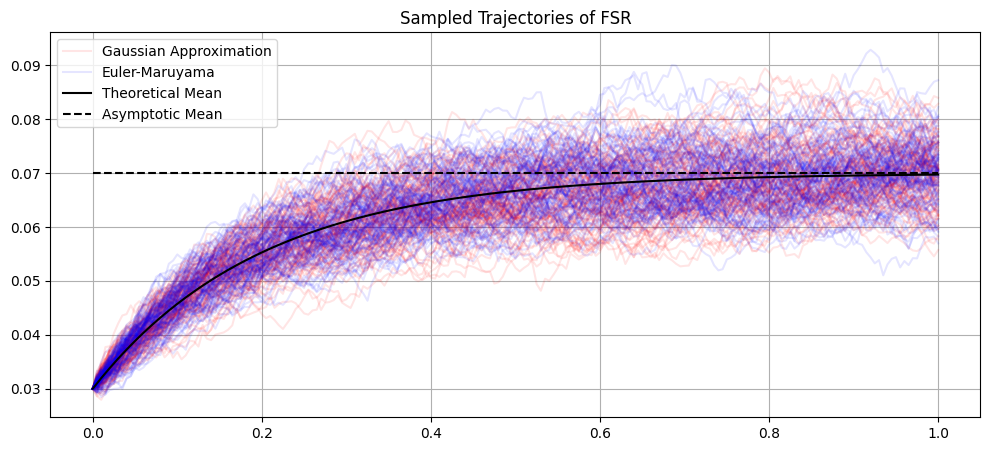

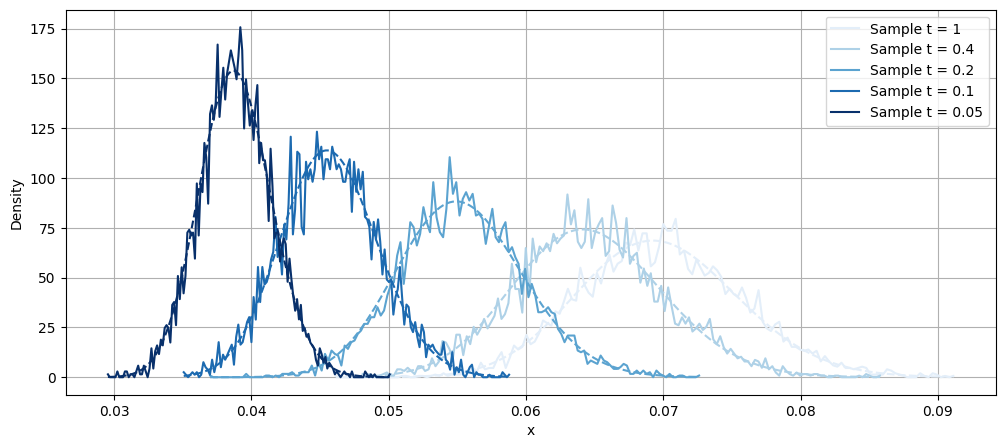

In [33]:
# Trajectories and Slices
# Plotting ====================================================================
# Trajectories ----------------------------------------------------------------
plt.figure(figsize = (12, 5), clear = True)

plt.title("Sampled Trajectories of FSR")
# Samples
plt.plot(t_steps, X[:, 0:100], color = 'red', alpha = 0.1, label = "Gaussian Approximation")
plt.plot(t_steps, Y[:, 100:200], color = 'blue', alpha = 0.1, label = "Euler-Maruyama")

# Theoretical and Asymptotic Mean
plt.plot(t_steps, exact_mean, color = 'black', linestyle = '-', label = 'Theoretical Mean')
plt.plot(t_steps, np.full(N_STEPS + 1, MU), color = 'black', linestyle = '--', label = 'Asymptotic Mean')

# Add legend and grid
handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()

plt.show()

# Slices ---------------------------------------------------------------------
SLICES = [0.05, 0.1, 0.2, 0.4, 1]       # FIXME: times to plot

plt.figure(figsize = (12, 5), clear = True)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES))) # Inverse grey color direction

for i, time in enumerate(SLICES[::-1]):
    p, x = np.histogram(X[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Compute theoretical density
    k = SIGMA**2 * (1 - np.exp(-ALPHA * time)) / (4 * ALPHA)
    d = 4 * ALPHA * MU / SIGMA**2
    l = 4 * ALPHA * X0 / (SIGMA**2 * (np.exp(ALPHA * time) - 1)) # Non-centrality parameter

    plt.plot(x, p, color = colors[i], linestyle = "-", label = f"Sample t = {time}")
    plt.plot(x, stats.ncx2.pdf(x / k, df = d, nc = l) / k, color = colors[i], linestyle = "--")

plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

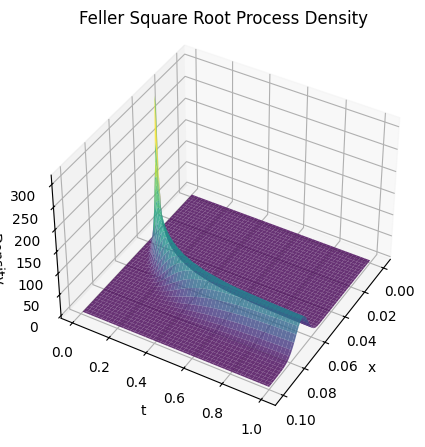

In [34]:
# 3D Plot --------------------------------------------------------------------

def fsr_density(x, t):
    k = SIGMA**2 * (1 - np.exp(-ALPHA * t)) / (4 * ALPHA)
    d = 4 * ALPHA * MU / SIGMA**2
    l = 4 * ALPHA * X0 / (SIGMA**2 * (np.exp(ALPHA * t) - 1)) # Non-centrality parameter
    return stats.ncx2.pdf(x / k, df = d, nc = l) / k

# Create meshgrid
x_grid = np.linspace(0, 0.1, 100)
t_grid = np.linspace(0.01, 1, 100) # Avoid t = 0 for numerical stability
XV, TV = np.meshgrid(x_grid, t_grid)
ZV = fsr_density(XV, TV)

# Plot
fig = plt.figure(figsize = (12, 5), clear = True)
ax = fig.add_subplot(111, projection = '3d')

ax.set_title('Feller Square Root Process Density')
ax.plot_surface(XV, TV, ZV, cmap = plt.cm.viridis, alpha = 0.8)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Density')

# Angle
ax.view_init(40, 30)
plt.show()

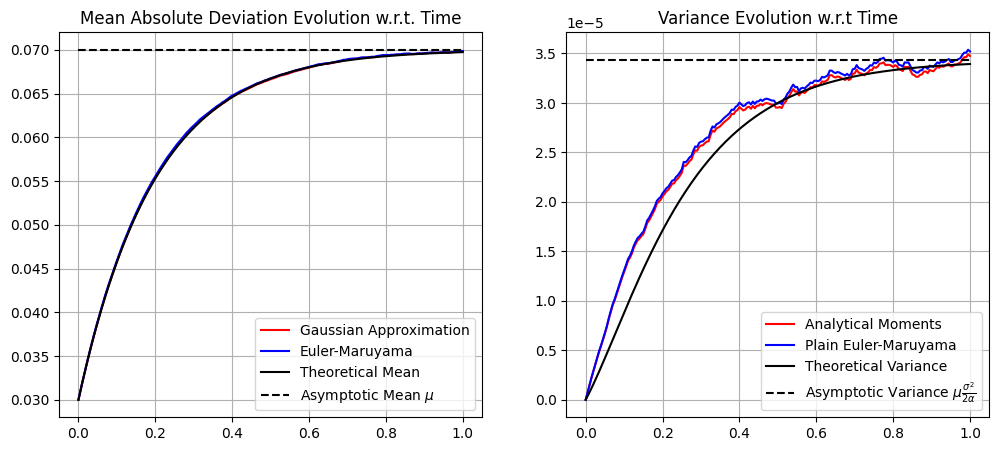

In [35]:
# Plotting MAD and Variance ===========================================================
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

ax[0].set_title("Mean Absolute Deviation Evolution w.r.t. Time")

# Mean Convergence ------------------------------------------------------------------
ax[0].plot(t_steps, X.mean(axis = 1), color = "red", label = "Gaussian Approximation")
ax[0].plot(t_steps, Y.mean(axis = 1), color = "blue", label = "Euler-Maruyama")

# Theoretical and Asymptotic Mean
ax[0].plot(t_steps, exact_mean, color = "black", label = r"Theoretical Mean")
ax[0].plot(t_steps, np.full(N_STEPS + 1, MU), color = "black", linestyle = "--", label = r"Asymptotic Mean $\mu$")

ax[0].grid()
ax[0].legend()

ax[1].set_title("Variance Evolution w.r.t Time")

# Variance Convergence --------------------------------------------------------------
ax[1].plot(t_steps, X.var(axis = 1), color = "red", label = "Analytical Moments")
ax[1].plot(t_steps, Y.var(axis = 1), color = "blue", label = "Plain Euler-Maruyama")

# Theoretical and Asymptotic Variance
ax[1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance")
ax[1].plot(t_steps, np.full(N_STEPS + 1, MU * SIGMA**2 / (2 * ALPHA)), color = "black", linestyle = "--", label = r"Asymptotic Variance $\mu\frac{\sigma^2}{2\alpha}$")

ax[1].grid()
ax[1].legend()

plt.show()

NameError: name 'exact_acov' is not defined

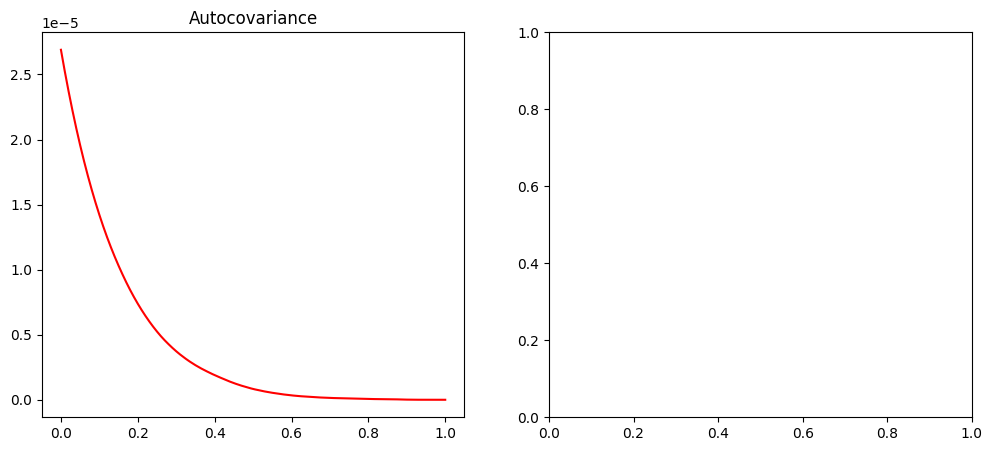

In [36]:
# Plotting Auto-covariance and Auto-correlation
# Compute autocovariance
sample_acov = np.zeros((N_STEPS * 2 + 1, N_SIMS))
for i in range(N_SIMS):
    sample_acov[:, i] = np.correlate(X[:, i] - exact_mean, X[:, i] - exact_mean, mode = "full") / N_STEPS
sample_acov = sample_acov[N_STEPS:].mean(axis = 1)
# exact_acov = # TODO: compute theoretical autocovariance

# Compute autocorrelation
sample_acor = sample_acov / sample_acov[0]
# exact_acor = # UNKNOWN

# Plotting ============================================================================
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

# Auto-covariance ---------------------------------------------------------------------
ax[0].set_title("Autocovariance")
ax[0].plot(t_steps, sample_acov, color = "red", label = "Sample")
ax[0].plot(t_steps, exact_acov, color = "black", label = "Theoretical")

# Plotting sample and theoretical variance
ax[0].plot(0, SIGMA**2 / (2 * ALPHA), 'o', color = "black", label = 'Var for infinite t_steps')
ax[0].plot(0, np.mean(np.var(X, axis=1)), 'o', color = "red", label = 'Sampled Var')

ax[0].legend()
ax[0].grid()

# Auto-correlation --------------------------------------------------------------------
ax[1].set_title("Autocorrelation")

ax[1].plot(t_steps, sample_acov, color = "red", label = "Sample")
# ax[1].plot(t_steps, exact_acov, color = "black", label = "Theoretical")

ax[1].grid()
ax[1].legend()

plt.show()

## CEV Process (Constant Elasticity of Variance)

![CEV Process](cev_process.png)